## 高斯金字塔
高斯金字塔中的较高级别（低分辨率）是通过删除较低级别（较高分辨率）图像中的连续行和列而形成的。然后，较高级别的每个像素由基础级别的5个像素的贡献与高斯权重形成。  

**cv.pyrDown**()和**cv.pyrUp**()用来得到高斯金字塔每一级图像  
注意分辨率降低后升高无法得到原图,信息会有丢失

(342, 548, 3)
(171, 274, 3)
(86, 137, 3)
(43, 69, 3)


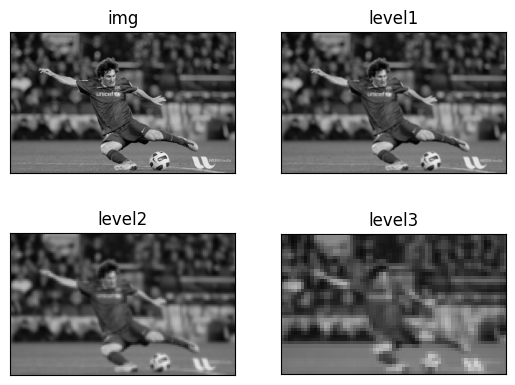

In [13]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import  _tools
img = cv.imread('../data/messi5.jpg',0)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
level1 = cv.pyrDown(img)
level2 = cv.pyrDown(level1)
level3 = cv.pyrDown(level2)
print(img.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

_tools.plot_image(221,img,"img")
_tools.plot_image(222,level1,"level1")
_tools.plot_image(223,level2,"level2")
_tools.plot_image(224,level3,"level3")

plt.show()




## 拉普拉斯金字塔
拉普拉斯金字塔由高斯金字塔形成。没有专用功能。  
拉普拉斯金字塔图像仅像边缘图像。它的大多数元素为零。  
它们用于图像压缩。  
**高斯金字塔中找到拉普拉斯金字塔的过程就是对高斯金字塔的每一层进行减法操作，得到相邻层之间的差异图像，这些差异图像构成了拉普拉斯金字塔。**

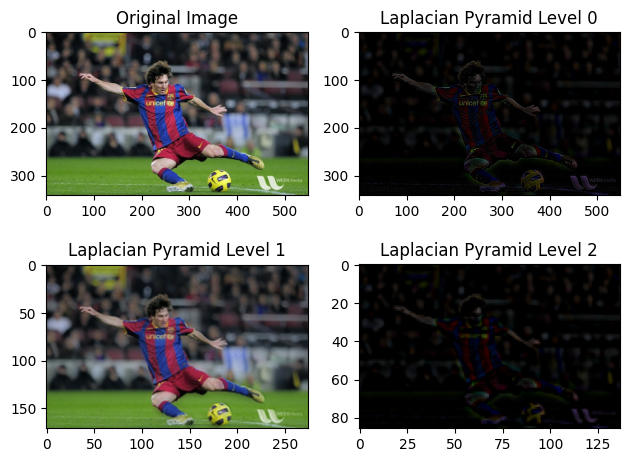

In [15]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# 读取图像并将颜色通道转换为RGB
img = cv.imread('../data/messi5.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# 构建高斯金字塔
level1 = cv.pyrDown(img)
level2 = cv.pyrDown(level1)
level3 = cv.pyrDown(level2)

# 重建拉普拉斯金字塔
reconstructed_level3 = cv.pyrUp(level3)
reconstructed_level3_resized = cv.resize(reconstructed_level3, (level2.shape[1], level2.shape[0]))
laplacian_level3 = cv.subtract(level2, reconstructed_level3_resized)

reconstructed_level2 = cv.pyrUp(laplacian_level3)
reconstructed_level2_resized = cv.resize(reconstructed_level2, (level1.shape[1], level1.shape[0]))
laplacian_level2 = cv.subtract(level1, reconstructed_level2_resized)

reconstructed_level1 = cv.pyrUp(laplacian_level2)
reconstructed_level1_resized = cv.resize(reconstructed_level1, (img.shape[1], img.shape[0]))
laplacian_img = cv.subtract(img, reconstructed_level1_resized)

# 显示图像和金字塔
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(laplacian_img)
axs[0, 1].set_title("Laplacian Pyramid Level 0")

axs[1, 0].imshow(laplacian_level2)
axs[1, 0].set_title("Laplacian Pyramid Level 1")

axs[1, 1].imshow(laplacian_level3)
axs[1, 1].set_title("Laplacian Pyramid Level 2")

plt.tight_layout()
plt.show()


## 图像融合
金字塔的一种应用是图像融合。例如，在图像拼接中，您需要将两个图像堆叠在一起，但是由于图像之间的不连续性，可能看起来不太好。在这种情况下，使用金字塔混合图像可以无缝混合，而不会在图像中保留大量数据。

In [ ]:
import cv2 as cv
import numpy as np
import  _tools

# 读取苹果和橙子图像
apple_img = cv.imread('../data/apple.jpg')
orange_img = cv.imread('../data/orange.jpg')

# 将图像从BGR颜色空间转换为RGB颜色空间
apple_img = cv.cvtColor(apple_img, cv.COLOR_BGR2RGB)
orange_img = cv.cvtColor(orange_img, cv.COLOR_BGR2RGB)

# 生成苹果图像的高斯金字塔
apple_pyramid = [apple_img]
g = apple_img.copy()
for i in range(6):
    g = cv.pyrDown(g)  # 对图像进行下采样
    apple_pyramid.append(g)

# 生成橙子图像的高斯金字塔
orange_pyramid = [orange_img]
g = orange_img.copy()
for i in range(6):
    g = cv.pyrDown(g)  # 对图像进行下采样
    orange_pyramid.append(g)

# 生成苹果图像的拉普拉斯金字塔
apple_laplacian = [apple_pyramid[5]]
for i in range(5, 0, -1):
    upsampled = cv.pyrUp(apple_pyramid[i])  # 对图像进行上采样
    laplacian = cv.subtract(apple_pyramid[i - 1], upsampled)  # 计算拉普拉斯差
    apple_laplacian.append(laplacian)

# 生成橙子图像的拉普拉斯金字塔
orange_laplacian = [orange_pyramid[5]]
for i in range(5, 0, -1):
    upsampled = cv.pyrUp(orange_pyramid[i])  # 对图像进行上采样
    laplacian = cv.subtract(orange_pyramid[i - 1], upsampled)  # 计算拉普拉斯差
    orange_laplacian.append(laplacian)

# 在每个级别中将左右两半图像合并
blended_pyramid = []
for apple_layer, orange_layer in zip(apple_laplacian, orange_laplacian):
    rows, cols, dpt = apple_layer.shape
    blended_layer = np.hstack((apple_layer[:, 0:cols // 2], orange_layer[:, cols // 2:]))
    blended_pyramid.append(blended_layer)

# 重建图像
result = blended_pyramid[0]
for i in range(1, 6):
    result = cv.pyrUp(result)  # 对图像进行上采样
    result = cv.add(result, blended_pyramid[i])  # 进行图像融合

# 图像与直接连接的每一半
cols = apple_img.shape[1]
merged_image = np.hstack((apple_img[:, :cols // 2], orange_img[:, cols // 2:]))

# 显示图像
_tools.plot_image(221, apple_img, "apple_img")
_tools.plot_image(222, orange_img, "orange_img")
_tools.plot_image(223, merged_image, "merged_image")
_tools.plot_image(224, result, "result")
plt.show()


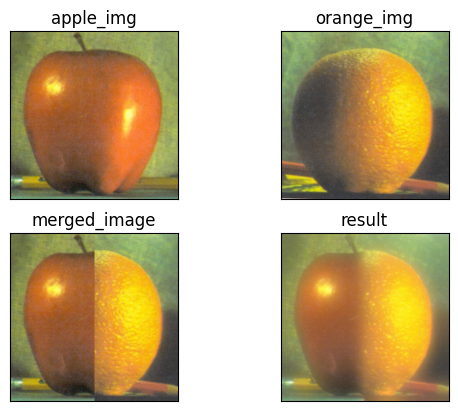

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import _tools

def load_images():
    """
    加载苹果和橙子的图像并转换为RGB颜色空间。

    Returns:
        apple_img: 加载的苹果图像
        orange_img: 加载的橙子图像
    """
    apple_img = cv.imread('../data/apple.jpg')
    orange_img = cv.imread('../data/orange.jpg')

    apple_img = cv.cvtColor(apple_img, cv.COLOR_BGR2RGB)
    orange_img = cv.cvtColor(orange_img, cv.COLOR_BGR2RGB)

    return apple_img, orange_img

def build_pyramid(image):
    """
    构建图像金字塔。

    Args:
        image: 输入的图像

    Returns:
        pyramid: 构建的金字塔图像列表
    """
    pyramid = [image]
    g = image.copy()
    for _ in range(6):
        g = cv.pyrDown(g)
        pyramid.append(g)

    return pyramid

def build_laplacian(pyramid):
    """
    构建拉普拉斯金字塔。

    Args:
        pyramid: 输入的图像金字塔

    Returns:
        laplacian: 构建的拉普拉斯金字塔图像列表
    """
    laplacian = [pyramid[5]]
    for i in range(5, 0, -1):
        upsampled = cv.pyrUp(pyramid[i])
        layer = cv.subtract(pyramid[i - 1], upsampled)
        laplacian.append(layer)

    return laplacian

def merge_images(apple_laplacian, orange_laplacian):
    """
    将苹果和橙子的拉普拉斯金字塔图像进行融合。

    Args:
        apple_laplacian: 苹果图像的拉普拉斯金字塔图像列表
        orange_laplacian: 橙子图像的拉普拉斯金字塔图像列表

    Returns:
        blended_pyramid: 融合后的金字塔图像列表
    """
    blended_pyramid = []
    for apple_layer, orange_layer in zip(apple_laplacian, orange_laplacian):
        rows, cols, dpt = apple_layer.shape
        blended_layer = np.hstack((apple_layer[:, 0:cols // 2], orange_layer[:, cols // 2:]))
        blended_pyramid.append(blended_layer)

    return blended_pyramid

def reconstruct_image(blended_pyramid):
    """
    根据融合金字塔图像重建原始图像。

    Args:
        blended_pyramid: 融合金字塔图像列表

    Returns:
        result: 重建的图像
    """
    result = blended_pyramid[0]
    for i in range(1, 6):
        result = cv.pyrUp(result)
        result = cv.add(result, blended_pyramid[i])

    return result

def main():
    apple_img, orange_img = load_images()

    apple_pyramid = build_pyramid(apple_img)
    orange_pyramid = build_pyramid(orange_img)

    apple_laplacian = build_laplacian(apple_pyramid)
    orange_laplacian = build_laplacian(orange_pyramid)

    blended_pyramid = merge_images(apple_laplacian, orange_laplacian)

    result = reconstruct_image(blended_pyramid)

    cols = apple_img.shape[1]
    merged_image = np.hstack((apple_img[:, :cols // 2], orange_img[:, cols // 2:]))

    _tools.plot_image(221, apple_img, "apple_img")
    _tools.plot_image(222, orange_img, "orange_img")
    _tools.plot_image(223, merged_image, "merged_image")
    _tools.plot_image(224, result, "result")
    plt.show()

if __name__ == '__main__':
    main()


In [5]:
import cv2 as cv
import numpy as np

def build_gaussian_pyramid(image, levels):
    pyramid = [image]
    temp = image.copy()
    for _ in range(levels):
        temp = cv.pyrDown(temp)
        pyramid.append(temp)
    return pyramid

def build_laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        expanded = cv.pyrUp(gaussian_pyramid[i + 1])
        if expanded.shape[:2] != gaussian_pyramid[i].shape[:2]:
            expanded = cv.resize(expanded, gaussian_pyramid[i].shape[:2][::-1])
        laplacian = cv.subtract(gaussian_pyramid[i], expanded)
        pyramid.append(laplacian)
    pyramid.append(gaussian_pyramid[-1])
    return pyramid

# 加载图像
image = cv.imread('../data/apple.jpg')

# 构建高斯金字塔
gaussian_pyramid = build_gaussian_pyramid(image, levels=5)

# 构建拉普拉斯金字塔
laplacian_pyramid = build_laplacian_pyramid(gaussian_pyramid)

# 显示原始图像和金字塔图像
cv.imshow('Original Image', image)
for i, laplacian in enumerate(laplacian_pyramid):
    cv.imshow(f'Laplacian Layer {i}', laplacian)

cv.waitKey(0)
cv.destroyAllWindows()
